# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Recherche du `pré-traitement` le plus adapté](#PREPROCESS)
    * [2.1 Tokenisation](#PREPROCESS_tokenized)
    * [2.2 Tokenisation + Filtrage](#PREPROCESS_filtered)
    * [2.3 Tokenisation + Filtrage + Lemmatisation](#PREPROCESS_lemmatized)
    * [2.4 Comparaison des scores](#PREPROCESS_scores)
* [3. Recherche du `plongement` le plus adapté](#EMBEDDING)
    * [3.1 Word2Vec](#EMBEDDING_Word2Vec)
    * [3.2 FastText](#EMBEDDING_FastText)
    * [3.3 Comparaison des scores](#EMBEDDING_scores)
* [4. Recherche du `modèle` de classification le plus adapté](#CLF)

In [1]:
import os
import time
import pathlib

import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
try:
    from keras.utils import pad_sequences
except ImportError:
    from keras.preprocessing.sequence import pad_sequences

import joblib

random_seed = 0
np.random.seed(random_seed)

# set random seed for keras reproductibility
try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-07-31 19:07:17.056080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [2]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_NN.csv")

#### Définissons les fonctions génériques de notre Spot Checking 

In [3]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

In [4]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [5]:
def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=10,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

#### Définissons nos fonctions de perte, d'optimisation et les métriques à surveiller

In [6]:
f_opti = "adam" # keras.optimizers.Adam(learning_rate=0.0005)
f_loss = "binary_crossentropy" # keras.losses.BinaryCrossentropy(from_logits=False)
f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()

#### Définissons une méthode de `cross-validation`

In [7]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

#### Définissons la taille de batch utilisé

In [8]:
batch_size = 8192 # 4096

---
---
# 2. Recherche du `pré-traitement` le plus adapté <a class="anchor" id="PREPROCESS"></a> [⇪](#menu)

Pour rechercher le pré-traitement le plus adapté, nous allons essayer différents jeux de données préparés lors de l'EDA.
Mais pour éviter tout autre changement, nous allons dans un premier temps définir une architecture NN simple et un Embedding de base que nous allons utiliser pour comparer l'influence des différents pré-traitement.

In [9]:
def architecture1(f_opti, f_loss, f_metrics, embedding):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

### Chargeons le jeu de données avec toutes les étapes de pré-processing faites dans 01_EDA.ipynb

In [10]:
data_full = pd.read_csv(pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_500000.csv'))
display(data_full.head(), data_full.shape)

,target,text,text_clean,tokens,tokens_filtered_advanced,tokens_filtered_simple,lemmas_filtered_advanced,lemmas_filtered_simple
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING...","OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING...","omg yes yes yes , degrassi 's on and i m watch...",omg yes yes yes watching finallllly <3,omg yes yes yes m watching finallllly <3,omg yes yes yes watch finallllly <3,omg yes yes yes m watch finallllly <3
1,1,@martyndarkly And it's an excuse to get a Wii.,And it's an excuse to get a Wii.,and it 's an excuse to get a wii .,excuse wii,excuse wii,excuse wii,excuse wii
2,0,@joerico I don't have a pool anymore The su...,I don't have a pool anymore The summer will be...,i do n't have a pool anymore the summer will b...,pool anymore summer long,pool anymore summer long,pool anymore summer long,pool anymore summer long
3,1,@araceli02 you know you were doing well with t...,you know you were doing well with trying to cl...,you know you were doing well with trying to cl...,know trying classify medical condition,know trying classify medical condition,know try classify medical condition,know try classify medical condition
4,1,btw i cant wait to get my tattoos,btw i cant wait to get my tattoos,btw i ca nt wait to get my tattoos,btw nt wait tattoos,btw nt wait tattoos,btw not wait tattoo,btw not wait tattoo


(464705, 8)

### Préparons les jeux de données des differents pré-processing

In [11]:
data_raw = data_full[['target','text']]
print("\n", " DATA RAW ".center(55, '-'))
display(data_raw.head(2), data_raw.shape)

data_preprocess_01 = data_full[['target','text_clean']]
print("\n", " DATA TWITTER-PREPROCESS ".center(55, '-'))
display(data_preprocess_01.head(2), data_preprocess_01.shape)

data_preprocess_02 = data_full[['target','tokens']]
print("\n", " DATA SpaCy TOKENS ".center(55, '-'))
display(data_preprocess_02.head(2), data_preprocess_02.shape)

data_preprocess_03 = data_full[['target','tokens_filtered_advanced']]
print("\n", " DATA SpaCy FILTERED TOKENS ".center(55, '-'))
display(data_preprocess_03.head(2), data_preprocess_03.shape)

data_preprocess_03_simple = data_full[['target','tokens_filtered_simple']]
print("\n", " DATA SpaCy FILTERED TOKENS (avec filtrage simple) ".center(55, '-'))
display(data_preprocess_03.head(2), data_preprocess_03.shape)

data_preprocess_04 = data_full[['target','lemmas_filtered_advanced']]
print("\n", " DATA SpaCy LEMMAS ".center(55, '-'))
display(data_preprocess_04.head(2), data_preprocess_04.shape)

data_preprocess_04_simple = data_full[['target','lemmas_filtered_simple']]
print("\n", " DATA SpaCy LEMMAS (avec filtrage simple) ".center(55, '-'))
display(data_preprocess_04.head(2), data_preprocess_04.shape)


 ----------------------- DATA RAW ----------------------


,target,text
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING..."
1,1,@martyndarkly And it's an excuse to get a Wii.


(464705, 2)


 --------------- DATA TWITTER-PREPROCESS ---------------


,target,text_clean
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING..."
1,1,And it's an excuse to get a Wii.


(464705, 2)


 ------------------ DATA SpaCy TOKENS ------------------


,target,tokens
0,1,"omg yes yes yes , degrassi 's on and i m watch..."
1,1,and it 's an excuse to get a wii .


(464705, 2)


 -------------- DATA SpaCy FILTERED TOKENS -------------


,target,tokens_filtered_advanced
0,1,omg yes yes yes watching finallllly <3
1,1,excuse wii


(464705, 2)


 -- DATA SpaCy FILTERED TOKENS (avec filtrage simple) --


,target,tokens_filtered_advanced
0,1,omg yes yes yes watching finallllly <3
1,1,excuse wii


(464705, 2)


 ------------------ DATA SpaCy LEMMAS ------------------


,target,lemmas_filtered_advanced
0,1,omg yes yes yes watch finallllly <3
1,1,excuse wii


(464705, 2)


 ------- DATA SpaCy LEMMAS (avec filtrage simple) ------


,target,lemmas_filtered_advanced
0,1,omg yes yes yes watch finallllly <3
1,1,excuse wii


(464705, 2)

---
## 2.1 RAW / Aucun pré-processing <a class="anchor" id="PREPROCESS_raw"></a> [⇪](#menu)

### Chargeons le jeu de données

In [12]:
display(data_raw.head(2), data_raw.shape)

,target,text
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING..."
1,1,@martyndarkly And it's an excuse to get a Wii.


(464705, 2)

In [13]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_raw['text'], data_raw.target, test_size=0.2, random_state=random_seed)

In [14]:
display(X_train.head(2), X_train.shape)

378347    @gotcoff33  i just might be making another one...
263306      ... not a man in 10,000 a poor girl can trust. 
Name: text, dtype: object

(371764,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [12]:
def preprocess_data_RAW(X_train, X_test, tokenizer_num_words=2000, padding_size=35, verbose=1):
    tokenizer = Tokenizer(num_words=tokenizer_num_words)
    tokenizer.fit_on_texts(X_train)

    dictionary = tokenizer.word_index
    vocab_size = len(dictionary)+1 # Adding 1 because of reserved 0 index
    
    X_train_enc = tokenizer.texts_to_sequences(X_train)
    X_test_enc = tokenizer.texts_to_sequences(X_test)
    
    X_train_ready = pad_sequences(X_train_enc, padding='post', maxlen=padding_size)
    X_test_ready = pad_sequences(X_test_enc, padding='post', maxlen=padding_size)
    
    # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
    # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
    
    if verbose > 0:
        print("----- One sample outputs for demo -----")
        print(f">> Original sentence: {X_train.iloc[0]}\n")
        print(f">> Tokenized sentence: {tokenizer.sequences_to_texts(X_train_ready[:1])}\n")
        print(f">> X_train_enc: {X_train_enc[:1]}\n")
        print(f">> X_train_ready: {X_train_ready[:1]}")
        
        print(f"\nVocab size: {vocab_size}")
    
    return X_train_ready, X_test_ready, tokenizer, vocab_size

In [16]:
token_num_words = 5000
padding_size = 50
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, token_num_words, padding_size)

----- One sample outputs for demo -----
>> Original sentence: @gotcoff33  i just might be making another one tonight! 

>> Tokenized sentence: ['i just might be making another one tonight']

>> X_train_enc: [[1, 20, 300, 23, 333, 204, 55, 121]]

>> X_train_ready: [[  1  20 300  23 333 204  55 121   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Vocab size: 253192


### Entrainons notre modèle

In [17]:
embedding_dim = 100
embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)

In [18]:
archi01_model_RAW = architecture1(f_opti, f_loss, f_metrics, embedding)

2022-07-31 17:05:59.395239: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-31 17:05:59.396255: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-31 17:05:59.455388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 17:05:59.456007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-07-31 17:05:59.456065: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-31 17:05:59.457708: I tensorflow/stream_executor/platform/default/dso_loade

In [19]:
archi01_model_RAW.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         25319200  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         89728     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512 

In [20]:
t0 = time.perf_counter()
history_clf_archi01_RAW = archi01_model_RAW.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_RAW")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50


2022-07-31 17:06:00.724109: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-31 17:06:00.743592: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2500005000 Hz
2022-07-31 17:06:01.369519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-31 17:06:01.908961: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-31 17:06:03.227055: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-31 17:06:03.318037: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


46/46 [==============================] - 25s 421ms/step - loss: 0.6667 - accuracy: 0.5645 - val_loss: 0.4784 - val_accuracy: 0.7781

Epoch 00001: val_accuracy improved from -inf to 0.77813, saving model to models/archi01_RAW.epoch01-accuracy0.78.hdf5
Epoch 2/50
46/46 [==============================] - 15s 328ms/step - loss: 0.4749 - accuracy: 0.7794 - val_loss: 0.4469 - val_accuracy: 0.7945

Epoch 00002: val_accuracy improved from 0.77813 to 0.79454, saving model to models/archi01_RAW.epoch02-accuracy0.79.hdf5
Epoch 3/50
46/46 [==============================] - 15s 327ms/step - loss: 0.4468 - accuracy: 0.7944 - val_loss: 0.4371 - val_accuracy: 0.7996

Epoch 00003: val_accuracy improved from 0.79454 to 0.79960, saving model to models/archi01_RAW.epoch03-accuracy0.80.hdf5
Epoch 4/50
46/46 [==============================] - 15s 328ms/step - loss: 0.4332 - accuracy: 0.8021 - val_loss: 0.4311 - val_accuracy: 0.8016

Epoch 00004: val_accuracy improved from 0.79960 to 0.80159, saving model to

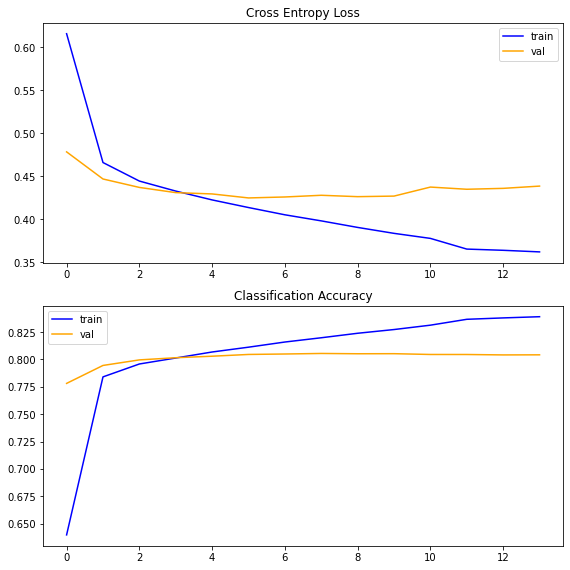

In [21]:
summarize_diagnostics(history_clf_archi01_RAW)

### Affichons les scores du modèle

In [22]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

(92941, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + TF-IDF) ----------------------------------------------------------------------

             ROC_AUC : 0.8828
                  F1 : 0.8004
            ACCURACY : 0.8016
           PRECISION : 0.7968
              RECALL : 0.8041
   AVERAGE_PRECISION : 0.8820

       TRAINING-TIME : 225.8704
      INFERENCE-TIME : 4.8715

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.81      0.80      0.80     46958
Prediction = 1       0.80      0.80      0.80     45983

      accuracy                           0.80     92941
     macro avg      

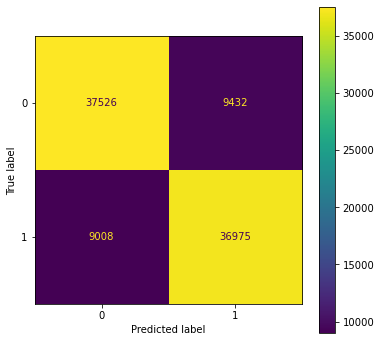

--- ROC AUC ---------------------------------------------------------------------------------------- 



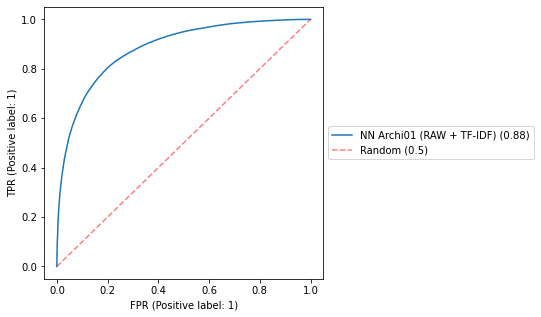

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



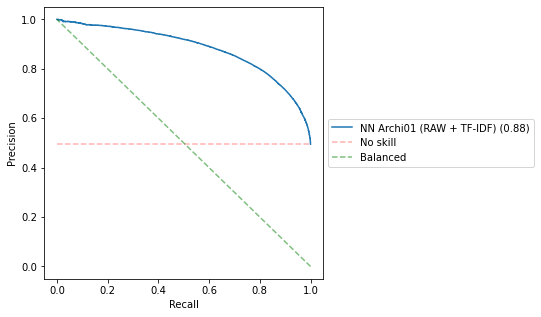

In [23]:
model_name = "NN Archi01 (RAW + Tokenizer)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.2 Preprocessing 01 / Twitter-Preprocessor <a class="anchor" id="PREPROCESS_01"></a> [⇪](#menu)
> Pour ce jeu de données on à utiliser la librairie python [tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/) afin de supprimer les MENTIONS, les URL et mots réservés *(RT, FAV, ...)*

### Chargeons le jeu de données

In [24]:
display(data_preprocess_01.head(2), data_preprocess_01.shape)

,target,text_clean
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING..."
1,1,And it's an excuse to get a Wii.


(464705, 2)

In [25]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_01['text_clean'], data_raw.target, test_size=0.2, random_state=random_seed)

In [26]:
display(X_train.head(2), X_train.shape)

378347       i just might be making another one tonight!
263306    ... not a man in 10,000 a poor girl can trust.
Name: text_clean, dtype: object

(371764,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [27]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, token_num_words, padding_size)

----- One sample outputs for demo -----
>> Original sentence: i just might be making another one tonight!

>> Tokenized sentence: ['i just might be making another one tonight']

>> X_train_enc: [[1, 20, 296, 23, 326, 200, 55, 120]]

>> X_train_ready: [[  1  20 296  23 326 200  55 120   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Vocab size: 129372


### Entrainons notre modèle

In [28]:
embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)

In [29]:
archi01_model_PP01 = architecture1(f_opti, f_loss, f_metrics, embedding)

In [30]:
archi01_model_PP01.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         12937200  
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         89728     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1651

In [31]:
t0 = time.perf_counter()
history_clf_archi01_PP01 = archi01_model_PP01.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_PP01")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
46/46 [==============================] - 13s 264ms/step - loss: 0.6627 - accuracy: 0.5742 - val_loss: 0.4778 - val_accuracy: 0.7784

Epoch 00001: val_accuracy improved from -inf to 0.77839, saving model to models/archi01_PP01.epoch01-accuracy0.78.hdf5
Epoch 2/50
46/46 [==============================] - 12s 262ms/step - loss: 0.4749 - accuracy: 0.7791 - val_loss: 0.4460 - val_accuracy: 0.7966

Epoch 00002: val_accuracy improved from 0.77839 to 0.79661, saving model to models/archi01_PP01.epoch02-accuracy0.80.hdf5
Epoch 3/50
46/46 [==============================] - 12s 262ms/step - loss: 0.4468 - accuracy: 0.7953 - val_loss: 0.4370 - val_accuracy: 0.7997

Epoch 00003: val_accuracy improved from 0.79661 to 0.79968, saving model to models/archi01_PP01.epoch03-accuracy0.80.hdf5
Epoch 4/50
46/46 [==============================] - 12s 263ms/step - loss: 0.4346 - accuracy: 0.8020 - val_loss: 0.4331 - val_accuracy: 0.8008

Epoch 00004: val_accuracy improved from 0.79968 to 0.80084, s

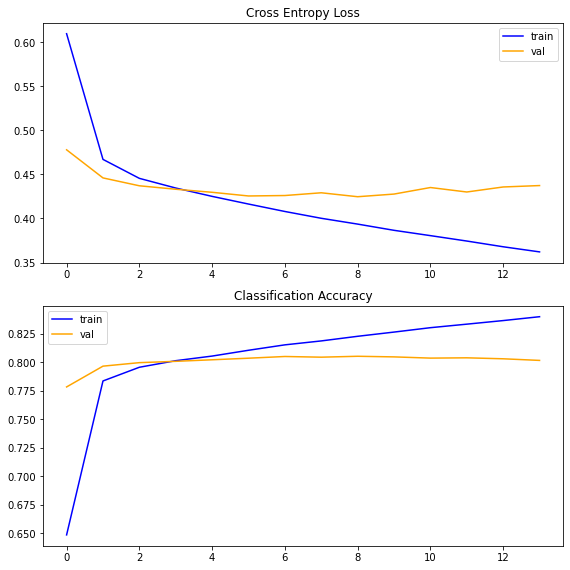

In [32]:
summarize_diagnostics(history_clf_archi01_PP01)

### Affichons les scores du modèle

In [33]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_PP01.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(92941, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS01 + Tokenizer) ----------------------------------------------------------

             ROC_AUC : 0.8818
                  F1 : 0.7989
            ACCURACY : 0.8008
           PRECISION : 0.7982
              RECALL : 0.7996
   AVERAGE_PRECISION : 0.8810

       TRAINING-TIME : 172.4034
      INFERENCE-TIME : 2.9244

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.80      0.80     46958
Prediction = 1       0.80      0.80      0.80     45983

      accuracy                           0.80     92941
     macro avg      

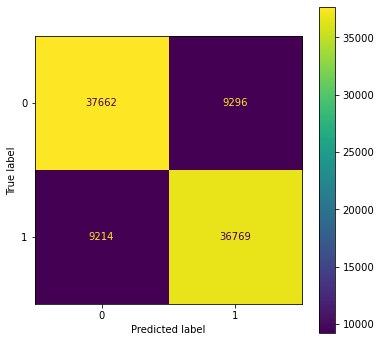

--- ROC AUC ---------------------------------------------------------------------------------------- 



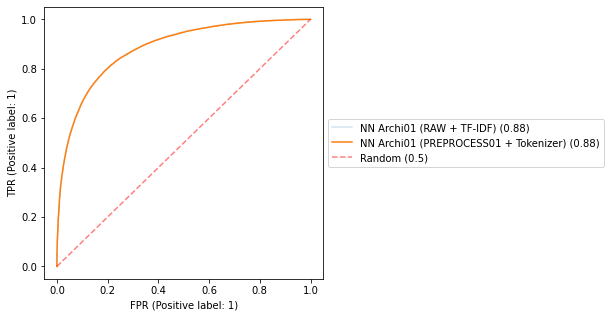

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



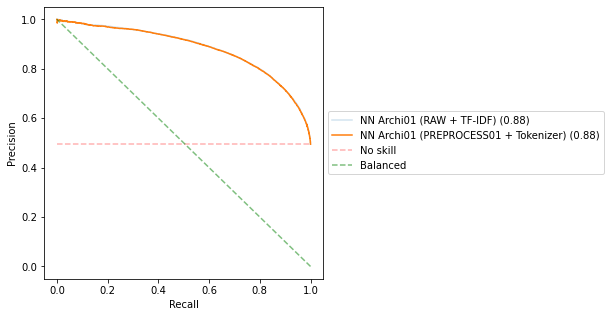

In [34]:
model_name = "NN Archi01 (PREPROCESS01 + Tokenizer)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.3 Preprocessing 02 / SpaCy Tokenization <a class="anchor" id="PREPROCESS_02"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_01) que l'on a Tokenisé en utilisant SpaCy. On en a profité pour supprimer les espaces en début et fin de ligne et pour retirer les majuscules *(était-ce une bonne idée ?)*

### Chargeons le jeu de données

In [35]:
display(data_preprocess_02.head(2), data_preprocess_02.shape)

,target,tokens
0,1,"omg yes yes yes , degrassi 's on and i m watch..."
1,1,and it 's an excuse to get a wii .


(464705, 2)

In [36]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_02['tokens'], data_raw.target, test_size=0.2, random_state=random_seed)

In [37]:
display(X_train.head(2), X_train.shape)

378347       i just might be making another one tonight !
263306    ... not a man in 10,000 a poor girl can trust .
Name: tokens, dtype: object

(371764,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [38]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, token_num_words, padding_size)

----- One sample outputs for demo -----
>> Original sentence: i just might be making another one tonight !

>> Tokenized sentence: ['i just might be making another one tonight']

>> X_train_enc: [[1, 23, 294, 27, 328, 204, 60, 126]]

>> X_train_ready: [[  1  23 294  27 328 204  60 126   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Vocab size: 122162


### Entrainons notre modèle

In [39]:
embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)

In [40]:
archi01_model_PP02 = architecture1(f_opti, f_loss, f_metrics, embedding)

In [41]:
archi01_model_PP02.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         12216200  
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         89728     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1651

In [42]:
t0 = time.perf_counter()
history_clf_archi01_PP02 = archi01_model_PP02.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_PP02")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
46/46 [==============================] - 13s 267ms/step - loss: 0.6607 - accuracy: 0.5790 - val_loss: 0.4720 - val_accuracy: 0.7817

Epoch 00001: val_accuracy improved from -inf to 0.78171, saving model to models/archi01_PP02.epoch01-accuracy0.78.hdf5
Epoch 2/50
46/46 [==============================] - 12s 264ms/step - loss: 0.4710 - accuracy: 0.7816 - val_loss: 0.4451 - val_accuracy: 0.7956

Epoch 00002: val_accuracy improved from 0.78171 to 0.79558, saving model to models/archi01_PP02.epoch02-accuracy0.80.hdf5
Epoch 3/50
46/46 [==============================] - 12s 263ms/step - loss: 0.4460 - accuracy: 0.7958 - val_loss: 0.4376 - val_accuracy: 0.7994

Epoch 00003: val_accuracy improved from 0.79558 to 0.79938, saving model to models/archi01_PP02.epoch03-accuracy0.80.hdf5
Epoch 4/50
46/46 [==============================] - 12s 260ms/step - loss: 0.4343 - accuracy: 0.8021 - val_loss: 0.4325 - val_accuracy: 0.8009

Epoch 00004: val_accuracy improved from 0.79938 to 0.80091, s

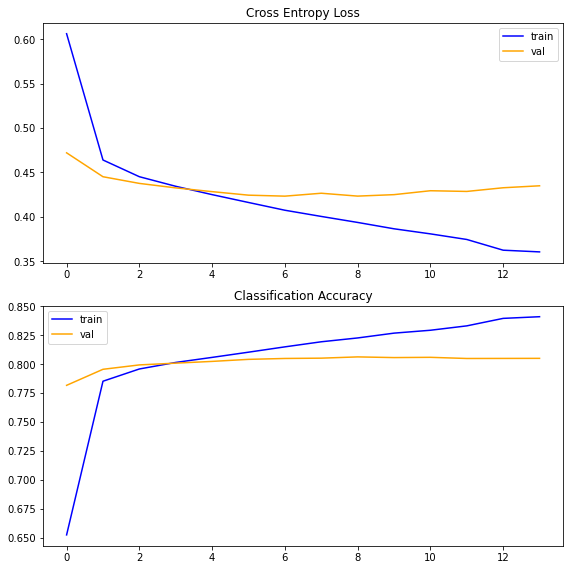

In [43]:
summarize_diagnostics(history_clf_archi01_PP02)

### Affichons les scores du modèle

In [44]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_PP02.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(92941, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS02 + Tokenizer) ----------------------------------------------------------

             ROC_AUC : 0.8817
                  F1 : 0.7979
            ACCURACY : 0.8009
           PRECISION : 0.8015
              RECALL : 0.7943
   AVERAGE_PRECISION : 0.8808

       TRAINING-TIME : 172.0194
      INFERENCE-TIME : 2.9123

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.81      0.80     46958
Prediction = 1       0.80      0.79      0.80     45983

      accuracy                           0.80     92941
     macro avg      

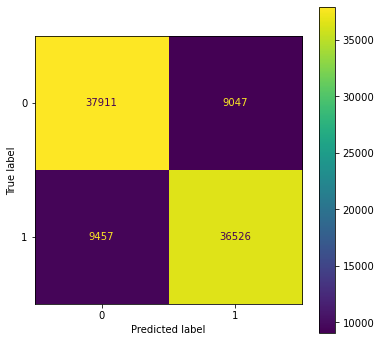

--- ROC AUC ---------------------------------------------------------------------------------------- 



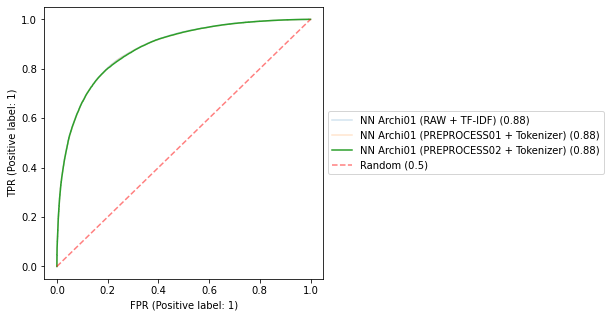

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



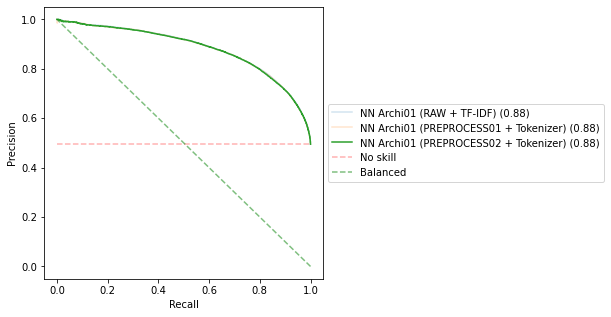

In [45]:
model_name = "NN Archi01 (PREPROCESS02 + Tokenizer)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.4 Preprocessing 03 / SpaCy Filtering <a class="anchor" id="PREPROCESS_03"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_02) que l'on a Filtré en utilisant les pos tags des tokens SpaCy collecté précèdement.

### Chargeons le jeu de données

In [46]:
display(data_preprocess_03.head(2), data_preprocess_03.shape)

,target,tokens_filtered_advanced
0,1,omg yes yes yes watching finallllly <3
1,1,excuse wii


(464705, 2)

In [47]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_03['tokens_filtered_advanced'], data_raw.target, test_size=0.2, random_state=random_seed)

In [48]:
display(X_train.head(2), X_train.shape)

378347                making tonight
263306    man 10,000 poor girl trust
Name: tokens_filtered_advanced, dtype: object

(371764,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [49]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, token_num_words, padding_size)

----- One sample outputs for demo -----
>> Original sentence: making tonight

>> Tokenized sentence: ['making tonight']

>> X_train_enc: [[170, 38]]

>> X_train_ready: [[170  38   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Vocab size: 99248


### Entrainons notre modèle

In [50]:
embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)

In [51]:
archi01_model_PP03 = architecture1(f_opti, f_loss, f_metrics, embedding)

In [52]:
archi01_model_PP03.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 100)         9924800   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 128)         89728     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1651

In [53]:
t0 = time.perf_counter()
history_clf_archi01_PP03 = archi01_model_PP03.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_PP03")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
46/46 [==============================] - 13s 265ms/step - loss: 0.6845 - accuracy: 0.5298 - val_loss: 0.5328 - val_accuracy: 0.7380

Epoch 00001: val_accuracy improved from -inf to 0.73801, saving model to models/archi01_PP03.epoch01-accuracy0.74.hdf5
Epoch 2/50
46/46 [==============================] - 12s 254ms/step - loss: 0.5260 - accuracy: 0.7466 - val_loss: 0.4965 - val_accuracy: 0.7594

Epoch 00002: val_accuracy improved from 0.73801 to 0.75944, saving model to models/archi01_PP03.epoch02-accuracy0.76.hdf5
Epoch 3/50
46/46 [==============================] - 12s 254ms/step - loss: 0.4953 - accuracy: 0.7631 - val_loss: 0.4923 - val_accuracy: 0.7616

Epoch 00003: val_accuracy improved from 0.75944 to 0.76157, saving model to models/archi01_PP03.epoch03-accuracy0.76.hdf5
Epoch 4/50
46/46 [==============================] - 12s 252ms/step - loss: 0.4878 - accuracy: 0.7673 - val_loss: 0.4911 - val_accuracy: 0.7616

Epoch 00004: val_accuracy improved from 0.76157 to 0.76162, s

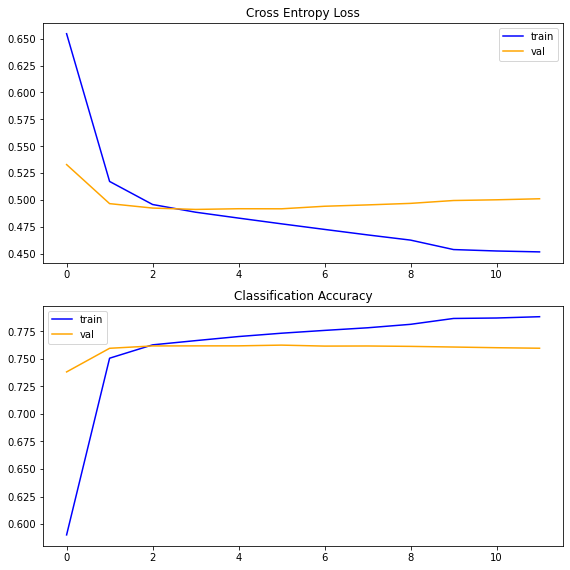

In [54]:
summarize_diagnostics(history_clf_archi01_PP03)

### Affichons les scores du modèle

In [55]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_PP03.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(92941, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS03 + Tokenizer) ----------------------------------------------------------

             ROC_AUC : 0.8389
                  F1 : 0.7608
            ACCURACY : 0.7594
           PRECISION : 0.7488
              RECALL : 0.7732
   AVERAGE_PRECISION : 0.8292

       TRAINING-TIME : 142.3188
      INFERENCE-TIME : 2.9696

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.75      0.76     46958
Prediction = 1       0.75      0.77      0.76     45983

      accuracy                           0.76     92941
     macro avg      

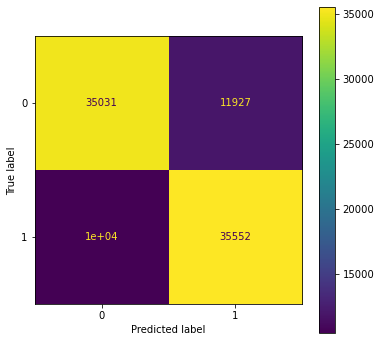

--- ROC AUC ---------------------------------------------------------------------------------------- 



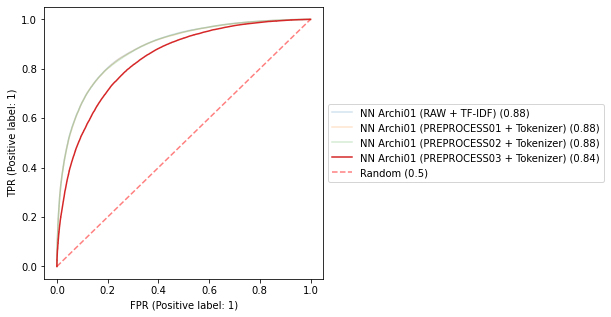

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



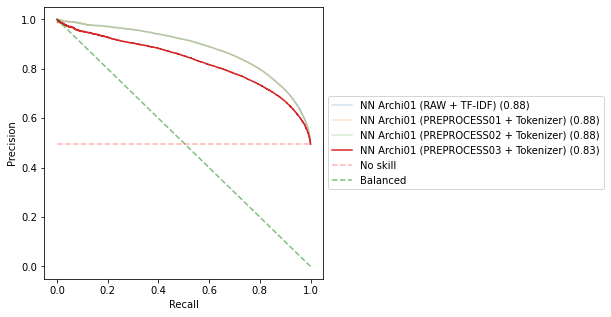

In [56]:
model_name = "NN Archi01 (PREPROCESS03 + Tokenizer)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

## Testons la même chose avec le jeu de données qui a été filtré avec des règles plus simples

---
## 2.5 Preprocessing 04 / SpaCy Lemmatization <a class="anchor" id="PREPROCESS_04"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_03) que l'on a Lemmatisé en utilisant SpaCy.

### Chargeons le jeu de données

In [57]:
display(data_preprocess_04.head(2), data_preprocess_04.shape)

,target,lemmas_filtered_advanced
0,1,omg yes yes yes watch finallllly <3
1,1,excuse wii


(464705, 2)

In [58]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_04['lemmas_filtered_advanced'], data_raw.target, test_size=0.2, random_state=random_seed)

In [59]:
display(X_train.head(2), X_train.shape)

378347                  make tonight
263306    man 10,000 poor girl trust
Name: lemmas_filtered_advanced, dtype: object

(371764,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [60]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, token_num_words, padding_size)

----- One sample outputs for demo -----
>> Original sentence: make tonight

>> Tokenized sentence: ['make tonight']

>> X_train_enc: [[79, 46]]

>> X_train_ready: [[79 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]

Vocab size: 87992


### Entrainons notre modèle

In [61]:
embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)

In [62]:
archi01_model_PP04 = architecture1(f_opti, f_loss, f_metrics, embedding)

In [63]:
archi01_model_PP04.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 100)         8799200   
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 128)         89728     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1651

In [64]:
t0 = time.perf_counter()
history_clf_archi01_PP04 = archi01_model_PP04.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_PP04")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
46/46 [==============================] - 12s 249ms/step - loss: 0.6819 - accuracy: 0.5380 - val_loss: 0.5311 - val_accuracy: 0.7398

Epoch 00001: val_accuracy improved from -inf to 0.73982, saving model to models/archi01_PP04.epoch01-accuracy0.74.hdf5
Epoch 2/50
46/46 [==============================] - 11s 246ms/step - loss: 0.5248 - accuracy: 0.7452 - val_loss: 0.5014 - val_accuracy: 0.7556

Epoch 00002: val_accuracy improved from 0.73982 to 0.75561, saving model to models/archi01_PP04.epoch02-accuracy0.76.hdf5
Epoch 3/50
46/46 [==============================] - 11s 247ms/step - loss: 0.4995 - accuracy: 0.7596 - val_loss: 0.4964 - val_accuracy: 0.7575

Epoch 00003: val_accuracy improved from 0.75561 to 0.75750, saving model to models/archi01_PP04.epoch03-accuracy0.76.hdf5
Epoch 4/50
46/46 [==============================] - 11s 243ms/step - loss: 0.4921 - accuracy: 0.7638 - val_loss: 0.4956 - val_accuracy: 0.7581

Epoch 00004: val_accuracy improved from 0.75750 to 0.75810, s

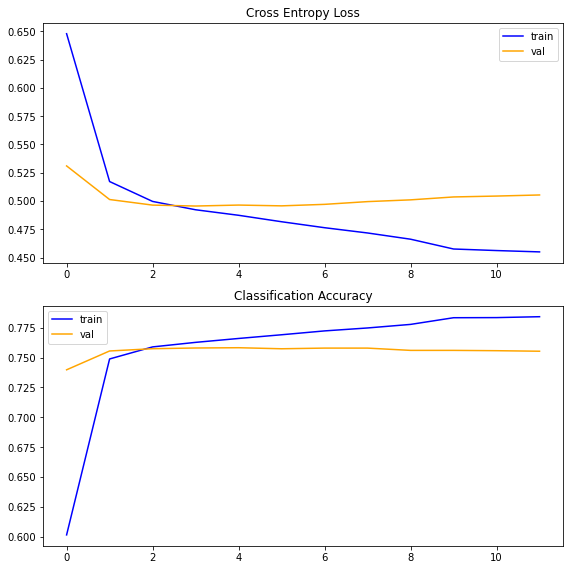

In [65]:
summarize_diagnostics(history_clf_archi01_PP04)

### Affichons les scores du modèle

In [66]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_PP04.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(92941, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS04 + Tokenizer) ----------------------------------------------------------

             ROC_AUC : 0.8360
                  F1 : 0.7590
            ACCURACY : 0.7556
           PRECISION : 0.7410
              RECALL : 0.7779
   AVERAGE_PRECISION : 0.8276

       TRAINING-TIME : 137.1864
      INFERENCE-TIME : 2.9577

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.73      0.75     46958
Prediction = 1       0.74      0.78      0.76     45983

      accuracy                           0.76     92941
     macro avg      

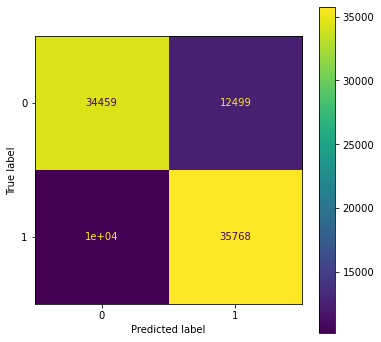

--- ROC AUC ---------------------------------------------------------------------------------------- 



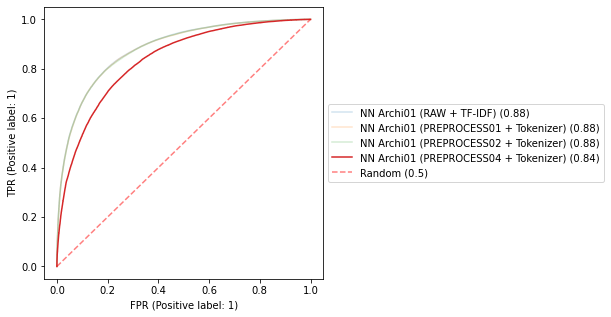

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



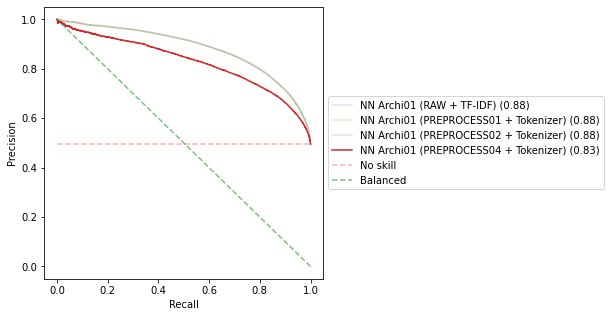

In [67]:
model_name = "NN Archi01 (PREPROCESS04 + Tokenizer)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

## Testons la même chose avec le jeu de données qui a été filtré avec des règles plus simples

### Chargeons le jeu de données

In [72]:
display(data_preprocess_04_simple.head(2), data_preprocess_04_simple.shape)

,target,lemmas_filtered_simple
0,1,omg yes yes yes m watch finallllly <3
1,1,excuse wii


(464705, 2)

In [73]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_04_simple['lemmas_filtered_simple'], data_raw.target, test_size=0.2, random_state=random_seed)

In [74]:
display(X_train.head(2), X_train.shape)

378347                  make tonight
263306    man 10,000 poor girl trust
Name: lemmas_filtered_simple, dtype: object

(371764,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [75]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, token_num_words, padding_size)

----- One sample outputs for demo -----
>> Original sentence: make tonight

>> Tokenized sentence: ['make tonight']

>> X_train_enc: [[80, 47]]

>> X_train_ready: [[80 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]

Vocab size: 88484


### Entrainons notre modèle

In [76]:
embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)

In [77]:
archi01_model_PP04s = architecture1(f_opti, f_loss, f_metrics, embedding)

In [78]:
archi01_model_PP04s.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 100)         8848400   
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 128)         89728     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1651

In [79]:
t0 = time.perf_counter()
history_clf_archi01_PP04s = archi01_model_PP04s.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_PP04s")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
46/46 [==============================] - 12s 246ms/step - loss: 0.6859 - accuracy: 0.5263 - val_loss: 0.5351 - val_accuracy: 0.7382

Epoch 00001: val_accuracy improved from -inf to 0.73823, saving model to models/archi01_PP04s.epoch01-accuracy0.74.hdf5
Epoch 2/50
46/46 [==============================] - 11s 245ms/step - loss: 0.5315 - accuracy: 0.7417 - val_loss: 0.5016 - val_accuracy: 0.7570

Epoch 00002: val_accuracy improved from 0.73823 to 0.75696, saving model to models/archi01_PP04s.epoch02-accuracy0.76.hdf5
Epoch 3/50
46/46 [==============================] - 11s 245ms/step - loss: 0.4992 - accuracy: 0.7605 - val_loss: 0.4946 - val_accuracy: 0.7588

Epoch 00003: val_accuracy improved from 0.75696 to 0.75885, saving model to models/archi01_PP04s.epoch03-accuracy0.76.hdf5
Epoch 4/50
46/46 [==============================] - 11s 244ms/step - loss: 0.4909 - accuracy: 0.7653 - val_loss: 0.4937 - val_accuracy: 0.7596

Epoch 00004: val_accuracy improved from 0.75885 to 0.75956

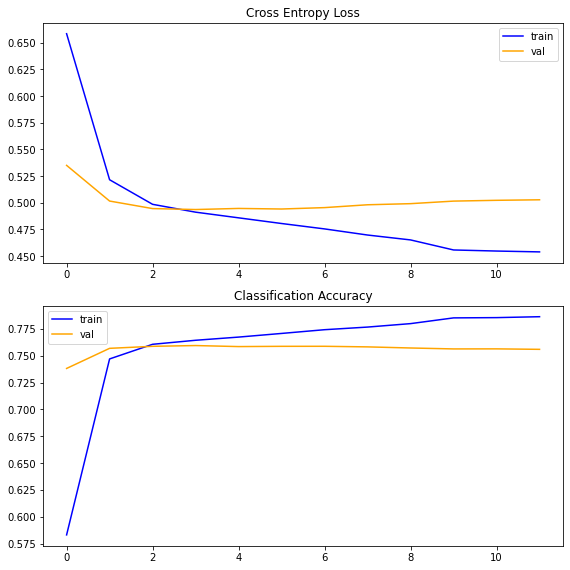

In [80]:
summarize_diagnostics(history_clf_archi01_PP04s)

### Affichons les scores du modèle

In [81]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_PP04s.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(92941, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS04_simple + Tokenizer) ---------------------------------------------------

             ROC_AUC : 0.8370
                  F1 : 0.7629
            ACCURACY : 0.7570
           PRECISION : 0.7373
              RECALL : 0.7904
   AVERAGE_PRECISION : 0.8276

       TRAINING-TIME : 136.7418
      INFERENCE-TIME : 2.9646

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.72      0.75     46958
Prediction = 1       0.74      0.79      0.76     45983

      accuracy                           0.76     92941
     macro avg      

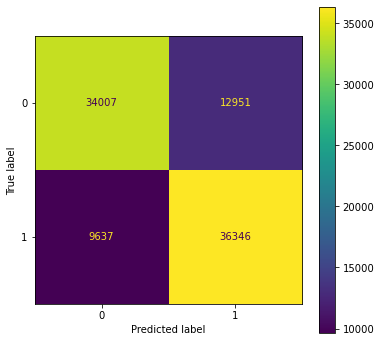

--- ROC AUC ---------------------------------------------------------------------------------------- 



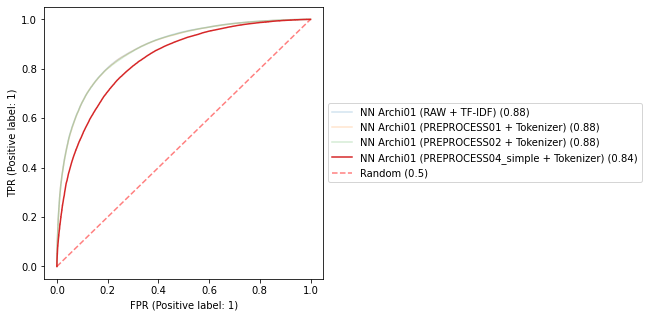

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



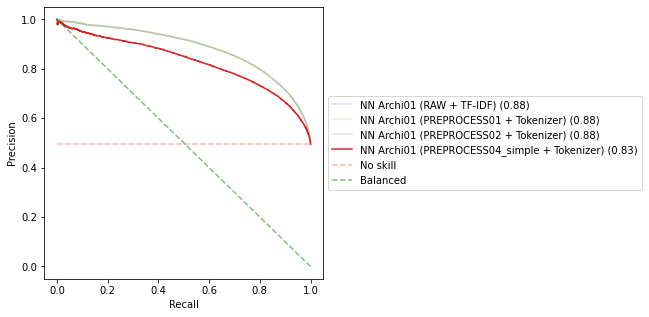

In [82]:
model_name = "NN Archi01 (PREPROCESS04_simple + Tokenizer)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.6 Comparaison des `scores` avec les différents pré-traitements <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [83]:
from classification_utils import scores_df

In [84]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,NN Archi01 (RAW + TF-IDF),None,None,0.882786,0.882002,0.800411,0.801595,0.796755,0.804102,36975,37526,9432,9008,225.870448,4.871482
1,NN Archi01 (PREPROCESS01 + Tokenizer),None,None,0.881811,0.881016,0.798909,0.800841,0.798198,0.799622,36769,37662,9296,9214,172.403352,2.924386
2,NN Archi01 (PREPROCESS02 + Tokenizer),None,None,0.881685,0.880834,0.797894,0.800906,0.801483,0.794337,36526,37911,9047,9457,172.019382,2.912281
3,NN Archi01 (PREPROCESS03 + Tokenizer),None,None,0.838894,0.829224,0.760780,0.759439,0.748794,0.773155,35552,35031,11927,10431,142.318750,2.969594
4,NN Archi01 (PREPROCESS04 + Tokenizer),None,None,0.835996,0.827572,0.759003,0.755608,0.741045,0.777853,35768,34459,12499,10215,137.186448,2.957702
5,NN Archi01 (PREPROCESS04_simple + Tokenizer),None,None,0.836951,0.827559,0.762930,0.756964,0.737286,0.790423,36346,34007,12951,9637,136.741802,2.964591


>#### Conclusion de la sélection du pré-traitement:
> - Le jeu de données RAW qui a juste été tokenisé *(split)* donne les meilleurs scores, mais prend beaucoup de temps à entrainer.
> - Les jeux de données FILTERED & LEMMATIZED ont des scores sensiblement équivalents, mais nettement inférieur à ceux du RAW.
> - Le jeu de données LEMMATIZED est le plus rapide à entrainer.
>
> A ce stade, si l'on veut augmenter nos scores il convient d'utiliser le jeu de données RAW.

---
---
# 3. Recherche du `plongement` le plus adapté <a class="anchor" id="EMBEDDING"></a> [⇪](#menu)

> https://fr.wikipedia.org/wiki/Word_embedding
>
> Pour utiliser les données en apprentissage machine, il est nécessaire de leur trouver une représentation mathématique, typiquement des vecteurs. Certaines données s'y prêtent directement, comme par exemple les images, qui engendrent des vecteurs riches en information, encodant toutes les nuances et les couleurs qui les composent. Les mots, quant à eux, sont des éléments d'information isolés, et certaines représentations rudimentaires se limitent à un simple identifiant par mot. Par exemple le mot « chat » sera encodé par un seul identifiant arbitraire, disons X87. C'est une représentation discrète, relativement pauvre, qui ne permet notamment pas de comparer deux mots entre eux5. Les plongements lexicaux, eux, représentent un mot par un vecteur. Par exemple, un chat sera représenté par le vecteur [0,43 0,88 0,98 1,3]. Si l'on encode tous les mots d'un dictionnaire ainsi, il devient alors **possible de comparer les vecteurs des mots entre eux**, par exemple en mesurant l'angle entre les vecteurs. Une bonne représentation de mots permettra alors de trouver que le mot « chien » est plus près du mot « chat » qu'il ne l'est du mot « gratte-ciel »6. Qui plus est, ces représentations permettent d'espérer que, dans l'espace vectoriel où le plongement est fait, on aura l'équation roi - homme + femme = reine ou encore l'équation Paris - France + Pologne = Varsovie7.
> 
> Les plongements lexicaux sont également très **utiles pour mitiger le fléau de la dimension**, un problème récurrent en intelligence artificielle. Sans les plongements de mots, **les identifiants uniques représentant les mots engendrent des données éparses**, des points isolés dans un espace vaste et presque vide6. Avec les plongements de mots, en revanche, l'espace devient beaucoup plus restreint et il est plus facile pour un ordinateur d'y établir des regroupements, d'y découvrir des régularités, en apprentissage machine. 

### Chargeons le jeu de données

In [12]:
display(data_raw.head(2), data_raw.shape)

,target,text
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING..."
1,1,@martyndarkly And it's an excuse to get a Wii.


(464705, 2)

In [13]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_raw['text'], data_raw.target, test_size=0.2, random_state=random_seed)

In [14]:
display(X_train.head(2), X_train.shape)

378347    @gotcoff33  i just might be making another one...
263306      ... not a man in 10,000 a poor girl can trust. 
Name: text, dtype: object

(371764,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [16]:
try:
    from tensorflow.keras.layers import TextVectorization
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

2022-07-31 18:18:09.733196: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-31 18:18:09.734148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-31 18:18:09.790708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 18:18:09.791290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-07-31 18:18:09.791328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-31 18:18:09.793010: I tensorflow/stream_executor/platform/default/dso_loade

In [17]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'i', 'to', 'the']

In [18]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([   4,  688,  837,   15,    4, 7121])

In [19]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [24]:
glove_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'glove.6B', 'glove.6B.100d.txt')

embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [25]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16432 words (3568 misses)


In [26]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [33]:
# X_train_ready, X_test_ready, tokenizer, vocab_size
X_train_ready = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test_ready = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

2022-07-31 18:23:47.237514: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594822400 exceeds 10% of free system memory.


In [36]:
X_train_ready, y_train

(array([[  1,   2,  21, ...,   0,   0,   0],
        [ 27,   5, 204, ...,   0,   0,   0],
        [ 21,  49,  53, ...,   0,   0,   0],
        ...,
        [ 17, 354,  10, ...,   0,   0,   0],
        [ 17,  87,  70, ...,   0,   0,   0],
        [  1,   8, 138, ...,   0,   0,   0]]),
 array([1, 0, 1, ..., 0, 1, 1]))

### Entrainons notre modèle

In [37]:
archi01_model_EM0 = architecture1(f_opti, f_loss, f_metrics, embedding_layer)

In [38]:
archi01_model_EM0.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000200   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         89728     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1651

In [39]:
t0 = time.perf_counter()
history_clf_archi01_EM0 = archi01_model_EM0.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_EM0")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

2022-07-31 18:24:20.135071: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594822400 exceeds 10% of free system memory.


Epoch 1/50


2022-07-31 18:24:21.082441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-31 18:24:21.804769: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-31 18:24:23.161730: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-31 18:24:23.276661: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


46/46 [==============================] - 27s 465ms/step - loss: 0.6902 - accuracy: 0.5437 - val_loss: 0.5906 - val_accuracy: 0.6943

Epoch 00001: val_accuracy improved from -inf to 0.69433, saving model to models/archi01_EM0.epoch01-accuracy0.69.hdf5
Epoch 2/50
46/46 [==============================] - 16s 355ms/step - loss: 0.6148 - accuracy: 0.6610 - val_loss: 0.5717 - val_accuracy: 0.7118

Epoch 00002: val_accuracy improved from 0.69433 to 0.71180, saving model to models/archi01_EM0.epoch02-accuracy0.71.hdf5
Epoch 3/50
46/46 [==============================] - 16s 355ms/step - loss: 0.5963 - accuracy: 0.6785 - val_loss: 0.5562 - val_accuracy: 0.7218

Epoch 00003: val_accuracy improved from 0.71180 to 0.72181, saving model to models/archi01_EM0.epoch03-accuracy0.72.hdf5
Epoch 4/50
46/46 [==============================] - 16s 356ms/step - loss: 0.5839 - accuracy: 0.6900 - val_loss: 0.5463 - val_accuracy: 0.7242

Epoch 00004: val_accuracy improved from 0.72181 to 0.72420, saving model to

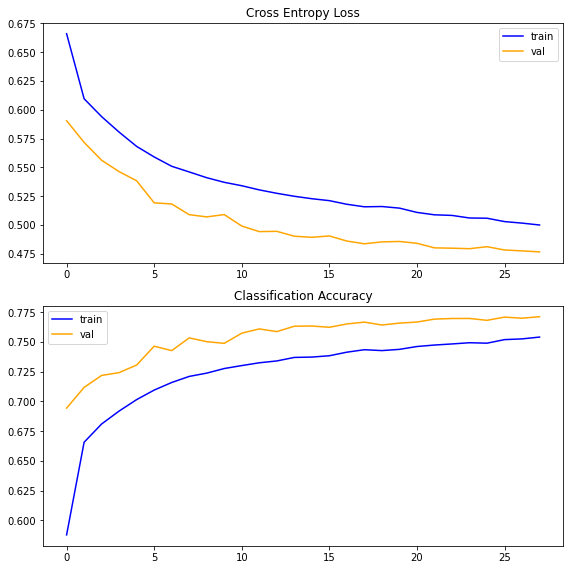

In [40]:
summarize_diagnostics(history_clf_archi01_EM0)

### Affichons les scores du modèle

In [41]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_EM0.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

(92941, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + EM0) -------------------------------------------------------------------------

             ROC_AUC : 0.8477
                  F1 : 0.7628
            ACCURACY : 0.7667
           PRECISION : 0.7674
              RECALL : 0.7582
   AVERAGE_PRECISION : 0.8448

       TRAINING-TIME : 474.9565
      INFERENCE-TIME : 6.6562

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.77      0.77     46958
Prediction = 1       0.77      0.76      0.76     45983

      accuracy                           0.77     92941
     macro avg      

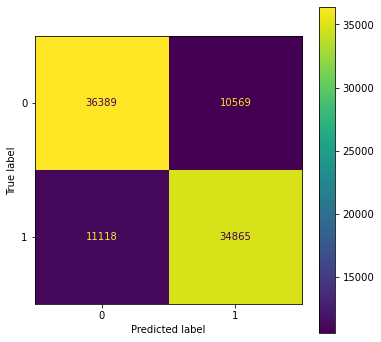

--- ROC AUC ---------------------------------------------------------------------------------------- 



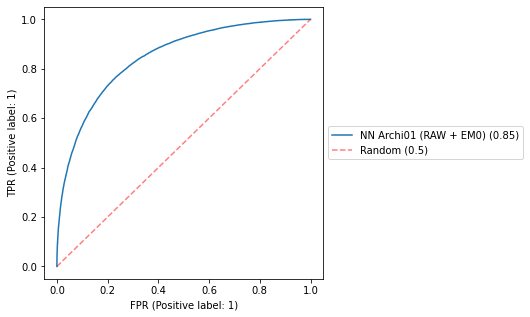

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



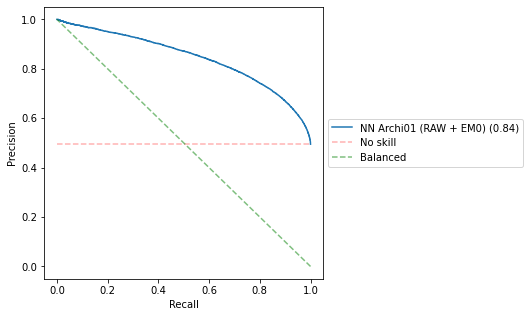

In [42]:
model_name = "NN Archi01 (RAW + EM0)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
---
---

### Chargeons le jeu de données

In [13]:
display(data_preprocess_04.head(2), data_preprocess_04.shape)

,target,lemmas_filtered_advanced
0,1,omg yes yes yes watch finallllly <3
1,1,excuse wii


(464705, 2)

In [14]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_04['lemmas_filtered_advanced'], data_raw.target, test_size=0.2, random_state=random_seed)

In [15]:
display(X_train.head(2), X_train.shape)

378347                  make tonight
263306    man 10,000 poor girl trust
Name: lemmas_filtered_advanced, dtype: object

(371764,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [16]:
try:
    from tensorflow.keras.layers import TextVectorization
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

2022-07-31 19:08:46.149271: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-31 19:08:46.150336: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-31 19:08:46.225755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 19:08:46.226370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-07-31 19:08:46.226421: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-31 19:08:46.317940: I tensorflow/stream_executor/platform/default/dso_loade

In [17]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'go', 'day', 'good']

In [18]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([16688,   344,  2180,  8475, 16688,  5338])

In [19]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [20]:
glove_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'glove.6B', 'glove.6B.100d.txt')

embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [21]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16586 words (3414 misses)


In [22]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [23]:
# X_train_ready, X_test_ready, tokenizer, vocab_size
X_train_ready = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test_ready = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [24]:
X_train_ready, y_train

(array([[  79,   47,    0, ...,    0,    0,    0],
        [ 102, 4865,  179, ...,    0,    0,    0],
        [   5,  899, 8198, ...,    0,    0,    0],
        ...,
        [ 200,  187,  302, ...,    0,    0,    0],
        [  19,   31,   62, ...,    0,    0,    0],
        [ 612, 1415, 2231, ...,    0,    0,    0]]),
 array([1, 0, 1, ..., 0, 1, 1]))

### Entrainons notre modèle

In [26]:
archi01_model_EM0 = architecture1(f_opti, f_loss, f_metrics, embedding_layer)

In [27]:
archi01_model_EM0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000200   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         89728     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1651

In [28]:
t0 = time.perf_counter()
history_clf_archi01_EM0 = archi01_model_EM0.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_EM0")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50


2022-07-31 19:09:34.675082: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-31 19:09:35.824789: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-31 19:09:38.236092: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-31 19:09:38.324775: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


46/46 [==============================] - 26s 434ms/step - loss: 0.6707 - accuracy: 0.5763 - val_loss: 0.5974 - val_accuracy: 0.6835

Epoch 00001: val_accuracy improved from -inf to 0.68353, saving model to models/archi01_EM0.epoch01-accuracy0.68.hdf5
Epoch 2/50
46/46 [==============================] - 16s 341ms/step - loss: 0.6169 - accuracy: 0.6547 - val_loss: 0.5828 - val_accuracy: 0.6962

Epoch 00002: val_accuracy improved from 0.68353 to 0.69621, saving model to models/archi01_EM0.epoch02-accuracy0.70.hdf5
Epoch 3/50
46/46 [==============================] - 16s 341ms/step - loss: 0.6050 - accuracy: 0.6678 - val_loss: 0.5669 - val_accuracy: 0.7066

Epoch 00003: val_accuracy improved from 0.69621 to 0.70659, saving model to models/archi01_EM0.epoch03-accuracy0.71.hdf5
Epoch 4/50
46/46 [==============================] - 16s 345ms/step - loss: 0.5910 - accuracy: 0.6808 - val_loss: 0.5593 - val_accuracy: 0.7115

Epoch 00004: val_accuracy improved from 0.70659 to 0.71155, saving model to

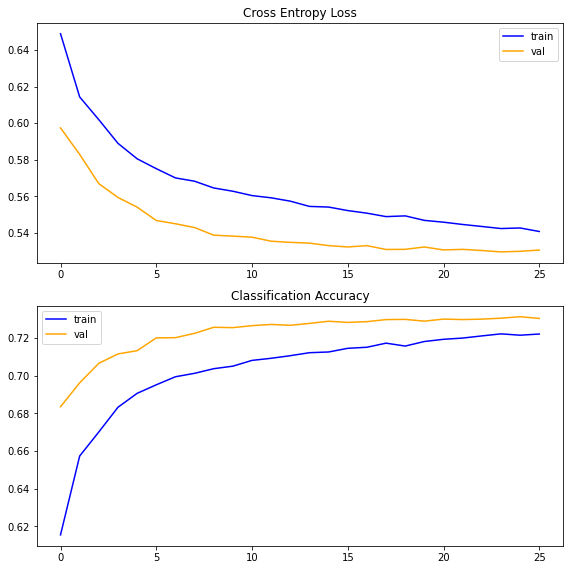

In [29]:
summarize_diagnostics(history_clf_archi01_EM0)

### Affichons les scores du modèle

In [30]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_EM0.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

(92941, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + EM0) -------------------------------------------------------------------------

             ROC_AUC : 0.8080
                  F1 : 0.7289
            ACCURACY : 0.7283
           PRECISION : 0.7197
              RECALL : 0.7383
   AVERAGE_PRECISION : 0.7976

       TRAINING-TIME : 418.5326
      INFERENCE-TIME : 5.9079

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.74      0.72      0.73     46958
Prediction = 1       0.72      0.74      0.73     45983

      accuracy                           0.73     92941
     macro avg      

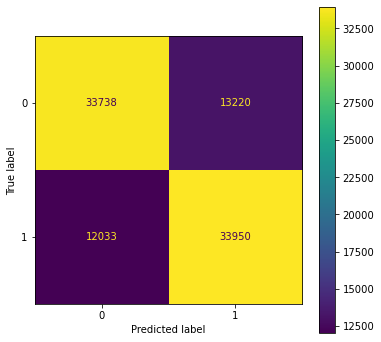

--- ROC AUC ---------------------------------------------------------------------------------------- 



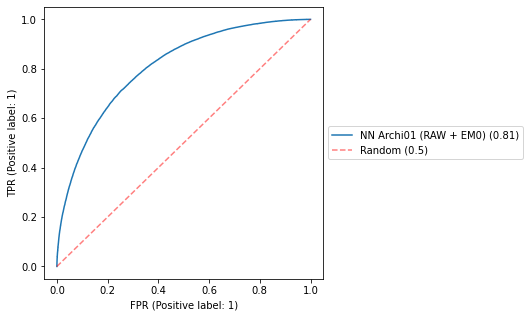

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



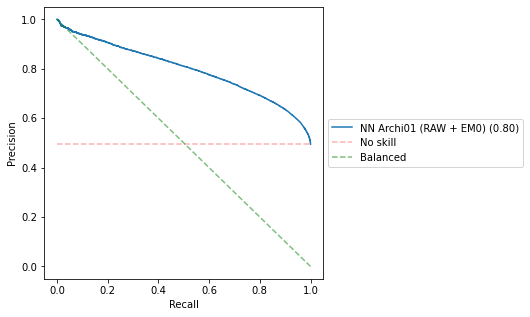

In [31]:
model_name = "NN Archi01 (RAW + EM0)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.1 Word2Vec <a class="anchor" id="EMBEDDING_Word2Vec"></a> [⇪](#menu)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(X_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [ ]:
pretrained_weights = w2v_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Embedding shape:', pretrained_weights.shape)

#### Regardons un peu ce que notre modèle propose comme mots similaires pour quelques mots choisi

In [ ]:
for word in ['good', 'bad', 'sad', 'fabulous', 'difficult', 'easy', 'boring', 'fun']:
    if word in w2v_model.wv:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in w2v_model.wv.most_similar(word)[:8])
        print(f'{word.rjust(15)} -> {most_similar}')
    else:
        print(f'⚠️ {word} is not in the Word2Vec vocabulary')

#### Mettons notre jeu de données au format requis par tensorflow/keras

In [ ]:
X_train.head()

In [ ]:
X_train_ready

In [ ]:
def word_embedding_transform(embedding_model, sentences, max_len=65):

    print('\nPreparing the data for Keras NN...')
    train_x = np.zeros([len(sentences), max_len], dtype=np.int32)
    for i, (id,sentence) in enumerate(sentences.iteritems()):
        for t, word in enumerate(sentence[:-1]):
            if word in embedding_model.wv.key_to_index:
                train_x[i, t] = embedding_model.wv.key_to_index[word]
                
    return train_x

In [ ]:
X_train_ready = word_embedding_transform(w2v_model, X_train)
print('X_train_ready shape:', X_train_ready.shape, 'y_train shape:', y_train.shape)

X_test_ready = word_embedding_transform(w2v_model, X_test)
print('X_test_ready shape:', X_test_ready.shape, 'y_test shape:', y_test.shape)

#### Ajoutons une fonction permettant de convertir notre embedding word2vec en layer tensorflow/keras

In [ ]:
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

### Entrainons notre Neural Network 

In [ ]:
embedding = gensim_to_keras_embedding(w2v_model, train_embeddings=True)

In [ ]:
archi01_model_RAW_Word2Vec = architecture1(f_opti, f_loss, f_metrics, embedding)

In [ ]:
archi01_model_RAW_Word2Vec.summary()

In [ ]:
t0 = time.perf_counter()
history_clf_archi01_RAW_Word2Vec = archi01_model_RAW_Word2Vec.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=batch_size, callbacks=init_callbacks("archi01_RAW_Word2Vec")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history_clf_archi01_RAW_Word2Vec)

### Affichons les scores du modèle

In [ ]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW_Word2Vec.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

In [ ]:
model_name = "NN Archi01 (RAW + Word2Vec)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.2 FastText <a class="anchor" id="EMBEDDING_FastText"></a> [⇪](#menu)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [ ]:
from gensim.models import FastText

In [ ]:
ft_model = FastText(X_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [ ]:
pretrained_weights = ft_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Embedding shape:', pretrained_weights.shape)

#### Regardons un peu ce que notre modèle propose comme mots similaires pour quelques mots choisi

In [ ]:
for word in ['good', 'bad', 'sad', 'fabulous', 'difficult', 'easy', 'boring', 'fun']:
    if word in ft_model.wv:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in ft_model.wv.most_similar(word)[:8])
        print(f'{word.rjust(15)} -> {most_similar}')
    else:
        print(f'⚠️ {word} is not in the Word2Vec vocabulary')

#### Mettons notre jeu de données au format requis par tensorflow/keras

In [ ]:
X_train_ready = word_embedding_transform(ft_model, X_train)
print('X_train_ready shape:', X_train_ready.shape, 'y_train shape:', y_train.shape)

X_test_ready = word_embedding_transform(ft_model, X_test)
print('X_test_ready shape:', X_test_ready.shape, 'y_test shape:', y_test.shape)

### Entrainons notre Neural Network 

In [ ]:
embedding = gensim_to_keras_embedding(ft_model, train_embeddings=True)

In [ ]:
archi01_model_RAW_FastText = architecture1(f_opti, f_loss, f_metrics, embedding)

In [ ]:
archi01_model_RAW_FastText.summary()

In [ ]:
t0 = time.perf_counter()
history_clf_archi01_RAW_FastText = archi01_model_RAW_FastText.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_RAW_FastText")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history_clf_archi01_RAW_FastText)

### Affichons les scores du modèle

In [ ]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW_FastText.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

In [ ]:
model_name = "NN Archi01 (RAW + FastText)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.3 Comparaison des `scores` avec les différents plongements <a class="anchor" id="EMBEDDING_scores"></a> [⇪](#menu)

In [ ]:
scores_df

>#### Conclusion de la sélection du plongement:
> TODO